## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium == 0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 02. Double DQN

[van Hasselt et al., "Deep Reinforcement Learning with Double Q-learning." arXiv preprint arXiv:1509.06461, 2015.](https://arxiv.org/pdf/1509.06461.pdf)




Let's take a close look at the difference between DQN and Double-DQN. The max operator in standard Q-learning and DQN uses the same values both to select and to evaluate an action. This makes it more likely to select overestimated values, resulting in overoptimistic value estimates.

$$
\theta_{t+1} = \theta_t + \alpha \big(Y_t^Q - Q(S_t, A_t; \theta_t)\big) \cdot \nabla_{\theta_t} Q(S_t, A_t; \theta_t),\\
\text{where } \alpha \text{ is a scalar step size and the target } Y_t^Q \text{is defined as }\\
Y_t^Q = R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta_t).
$$

In Double Q-learning ([van Hasselt 2010](https://papers.nips.cc/paper/3964-double-q-learning.pdf)), two value functions are learned by assigning experiences randomly to update one of the two value functions, resulting in two sets of weights, $\theta$ and $\theta'$. For each update, one set of weights is used to determine the greedy policy and the other to determine its value. For a clear comparison, we can untangle the selection and evaluation in Q-learning and rewrite DQN's target as

$$
Y_t^Q = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t).
$$

The Double Q-learning error can then be written as

$$
Y_t^{DoubleQ} = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta_t); \theta_t').
$$

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Although not fully decoupled, the target network in the DQN architecture provides a natural candidate for the second value function, without having to introduce additional networks. In conclusion, the weights of the second network $\theta_t'$ are replaced with the weights of the target network for the evaluation of the current greedy policy. This makes just a small change in calculating the target value of DQN loss.

##### DQN:

```
target = reward + gamma * dqn_target(next_state).max(dim=1, keepdim=True)[0]
```

##### DoubleDQN:

```
selected_action = dqn(next_state).argmax(dim=1, keepdim=True)
target = reward + gamma * dqn_target(next_state).gather(1, selected_action)
```
      

In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

/Users/jinwoo.park/miniforge3/envs/rainbow-is-all-you-need/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## Double DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

We use `self.dqn` instead of `self.dqn_target` for action selection.

```

        next_q_value = self.dqn_target(next_state).gather(
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)  # Double DQN
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)
```

In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).gather(  # Double DQN
            1, self.dqn(next_state).argmax(dim=1, keepdim=True)
        ).detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss
    
    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [6]:
# environment
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

## Set random seed

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [8]:
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 200
epsilon_decay = 1 / 2000

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cpu


## Train

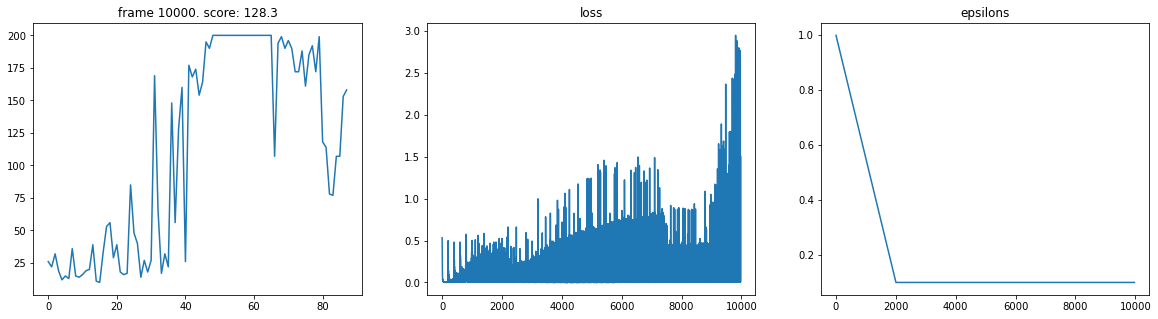

In [9]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [10]:
video_folder="videos/double_q"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/double_q/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/double_q/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/double_q/rl-video-episode-0.mp4
score:  170.0


## Render

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/double_q/rl-video-episode-0.mp4
